In [1]:

import os
import torch
import pickle
import random
import logging
import heartpy as hp
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from os import path
import pandas as pd
from tqdm import tqdm
from glob import glob
from pyedflib import highlevel as reader
from matplotlib import pyplot as plt
from src.datasets import SessionMeta,RPPG

/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# #read an edf file
# signals, signal_headers, header = reader.read_edf('/storage/HCI/Sessions/59/Part_1_Trial18_taggingImages1.bdf')
# signals.shape

In [3]:
# signal_labels = [x["label"] for x in signal_headers]
# print(signal_labels,f"len:{len(signal_labels)}")
# print("=============================")
# print(signal_labels.index("EXG1"))
# print(signal_labels.index("EXG2"))
# print(signal_labels.index("EXG3"))

In [4]:
# signal_headers

In [5]:
# hr_freq = signal_headers[32]["sample_frequency"]
# print(hr_freq)
# hr_skip = int(hr_freq * 5)
# hr_dur = int(hr_freq *10)
# hr_data = signals[33][hr_skip:hr_skip + hr_dur]
# plt.plot([i/hr_freq for i in range(len(hr_data))],hr_data)

In [6]:
# event_freq = signal_headers[46]["sample_frequency"]
# event_skip = int(event_freq * 29)
# event_data = signals[46][event_skip:-event_skip]
# plt.plot([i/event_freq for i in range(len(event_data))],event_data)

In [7]:
c = RPPG.get_default_config()
c.train_ratio = 1.0
c.compressions = ["c23"]
# c.meta_folder = None

# logging.basicConfig(level="INFO")
logging.basicConfig(level="DEBUG")
x = RPPG(c,50,10)

INFO:root:Meta folder specified, loading meta infos....
3810it [00:00, 66275.57it/s]
INFO:root:Session meta created.
DEBUG:root:Number of session metas before checking: 3810
INFO:root:Session meta filtered.
DEBUG:root:Current number of sessions: 3136
DEBUG:root:Number of session metas ready for training: 3136


In [8]:
for i in range(10):
    x[i]

DEBUG:root:Item/Session Index:0/0
DEBUG:root:rPPG Load Duration:0.03409242630004883
DEBUG:root:Loading video: ./datasets/hci/cropped_faces/c23/511/P4-Rec4-2009.07.21.18.57.23_C1 trigger _C_Section_21.avi
DEBUG:root:Sample Offset: 0.01639344262295082
DEBUG:root:Sample Stride: 0.20374707259953162
DEBUG:root:Video Load Duration:0.44592714309692383
DEBUG:root:Item Load Duration:0.4811680316925049
DEBUG:root:Item/Session Index:1/1
DEBUG:root:rPPG Load Duration:0.021964311599731445
DEBUG:root:Loading video: ./datasets/hci/cropped_faces/c23/59/P1-Rec2-2009.07.09.18.44.59_C1 trigger _C_Section_19.avi
DEBUG:root:Sample Offset: 0.0
DEBUG:root:Sample Stride: 0.20374707259953162
DEBUG:root:Video Load Duration:0.3780677318572998
DEBUG:root:Item Load Duration:0.40108489990234375
DEBUG:root:Item/Session Index:2/4
/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/numpy/ma/core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/o

In [11]:
print(len(x))
print(len(x.session_metas))

5565
3136


In [12]:
# for i in range(10):
#     idx = random.randrange(0,len(x))
#     r = x.get_dict(idx)
#     frames,label, masks = r["frames"],r["label"],r["mask"]
#     print(f"{idx} new",np.argmax(label)+41)
#     r = x.get_dict(idx,True)
#     frames,label, masks = r["frames"],r["label"],r["mask"]
#     print(f"{idx} old",np.argmax(label)+41)

In [15]:
frames,_,_,_ = x[0]

DEBUG:root:Item/Session Index:0/0
DEBUG:root:rPPG Load Duration:0.0283663272857666
DEBUG:root:Loading video: ./datasets/hci/cropped_faces/c23/511/P4-Rec4-2009.07.21.18.57.23_C1 trigger _C_Section_21.avi
DEBUG:root:Sample Offset: 0.01639344262295082
DEBUG:root:Sample Stride: 0.20374707259953162
DEBUG:root:Video Load Duration:0.4409351348876953
DEBUG:root:Item Load Duration:0.4707927703857422


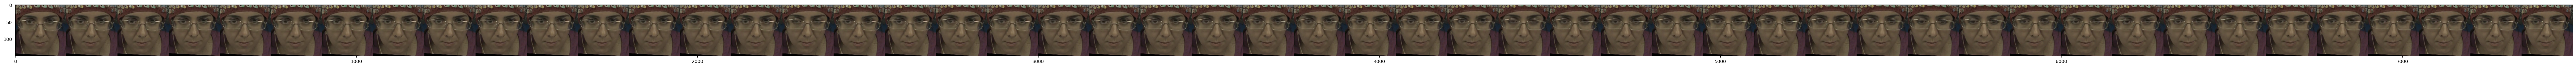

In [16]:
plt.figure(figsize=(100,150))
plt.imshow(np.stack(frames.numpy().transpose((0,2,3,1)),axis=1).reshape((150,-1,3)))

In [ ]:
# plt.plot(hr_data)

In [ ]:
r = x.get_dict(118,runtime=False)
measure = r["measure"]
# hr_data = r["hr_data"]
print(np.argmax(r["label"]))
# plt.plot(list(range(len(hr_data))),hr_data)


In [ ]:

for i in tqdm(range(len(x))):
    try:
        x[i]
    except Exception as e:
        print(i,e)

In [ ]:
# # dataset consistency
# rng = random.Random()
# rng.seed(777)
# session_dirs = sorted(glob(path.join('./datasets/hci/',"Sessions","*")))
# rng.shuffle(session_dirs)
# session_metas = [None for _ in range(len(session_dirs))]
# for i,session_dir in tqdm(enumerate(session_dirs)):
#     try:
#         with open(path.join(session_dir.replace("Sessions","Metas"),"meta.pickle"),"rb") as file:
#             session_metas[i] = pickle.load(file)
#     except:
#         print(f"Error Loading: {session_dir}.")
# session_metas = [
#     meta for meta in session_metas 
#     if meta and meta.require_check(
#         video=True,
#         bdf=True,
#         time=True,
#         video_folders=[]
#     )
# ]
# len(session_metas)

In [ ]:
import cv2
import os
import torch
import pickle
import random
import logging
import heartpy as hp
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from os import path
import pandas as pd
from tqdm import tqdm
from glob import glob
from pyedflib import highlevel as reader
from matplotlib import pyplot as plt
from src.datasets import SessionMeta,RPPG
cap = cv2.VideoCapture("./datasets/hci/cropped_faces/raw/511/P4-Rec4-2009.07.21.18.57.23_C1 trigger _C_Section_21.avi")
from time import time
a = time()
frames = []
next_sample_idx = 0
logging.info(f"v-mid{time()-a}")
a = time()
video_sample_stride = 3.7
for sample_idx in range(50):
    video_sample_idx = 300+next_sample_idx
    cap.set(cv2.CAP_PROP_POS_FRAMES,video_sample_idx)
    ret, frame = cap.read()
    if(ret):
        frames.append(torch.from_numpy(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB).transpose((2,0,1))))
        next_sample_idx = int(round((sample_idx+1) * video_sample_stride))
    else:
        raise Exception(f"unable to read video frame of sample index:{video_sample_idx}")
cap.release()
print(len(frames))
time()-a

In [ ]:
import torchvision
from itertools import islice
from time import time
reader = torchvision.io.VideoReader(
    "./datasets/hci/cropped_faces/c23/25/P1-Rec1-2009.07.09.17.53.46_C1 trigger _C_Section_25.avi", 
    "video"
    )
reader_md = reader.get_metadata()

print(reader_md)
a = time()
for i in range(50):
    reader.seek(0+i*video_sample_stride/61)
    frame = next(reader)
time()-a

In [ ]:

reader = torchvision.io.VideoReader(
    "./datasets/hci/cropped_faces/c23/25/P1-Rec1-2009.07.09.17.53.46_C1 trigger _C_Section_25.avi", 
    "video"
)
for i in range(50):
    reader.seek(int(10)+i*0.20374707259953162)
    frame = next(reader)
    frame["data"]

In [ ]:
reader_md["video"]["fps"]

In [ ]:
reader.seek(0)
frame = next(reader)
frame["data"][:,0,0]

In [ ]:
cap = cv2.VideoCapture("./datasets/hci/cropped_faces/raw/511/P4-Rec4-2009.07.21.18.57.23_C1 trigger _C_Section_21.avi")
ret,frame = cap.read()
cap.release()
frame[0,0]